# Regression Analysis on Bike Sharing Dataset 🚲📈

In this notebook, I will build upon the exploratory analysis previously conducted on the Bike Sharing dataset obtained from the UCI Machine Learning Repository. Our goal now is to model a system that can predict the bike count based on various attributes, including weather conditions and other factors.

#### Problem Statement

Given the Bike Sharing dataset with hourly level information of bikes along with weather and other attributes, our task is to develop a regression model capable of predicting the bike count accurately.

#### Regression Modeling Approach

We will employ linear regression as our modeling technique, The hourly bike count will be our target variable, while weather attributes, time-related features, and other relevant factors will serve as our predictors.

**Created by: José Rubén García García**

**March, 2024**


# **Regression analysis**

## Loading resources

In [1]:
%matplotlib inline
# data manuipulation
import numpy as np
import pandas as pd

# modeling utilities
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn


sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [2]:
#Loading the dataset
hour_df = pd.read_csv('hour.csv')
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


## Preprocessing 


In [3]:
#Standarize column names

hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [4]:
#Typecast attributes
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# variables to categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

### Encode Categorical (One Hot Encoding)
Since we have some categorical features always is a good idea to apply a categorical encode, the method that I will use is the one called as One hot encoding or "OHE" 

In [5]:
def fit_transform_ohe(df, col_name):
    """This function performs one hot encoding for the specified column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the mentioned column name.
        col_name (str): The column to be one hot encoded.

    Returns:
        tuple: LabelEncoder, OneHotEncoder, transformed column as pandas DataFrame.

    """
    # Label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # One hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le, ohe, features_df

def transform_ohe(df, le, ohe, col_name):
    """This function performs one hot encoding for the specified column using the specified encoder objects.

    Args:
        df (pandas.DataFrame): The DataFrame containing the mentioned column name.
        le (LabelEncoder): The label encoder object used to fit label encoding.
        ohe (OneHotEncoder): The OneHotEncoder object used to fit one hot encoding.
        col_name (str): The column to be one hot encoded.

    Returns:
        pandas.DataFrame: Transformed column as pandas DataFrame.

    """
    # Label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # One hot encoding
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df


### Train and test splitting


In [27]:
#splitting the train and test in a 67% - 33% relationship properly 
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3], hour_df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


In [11]:
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

### Normality test

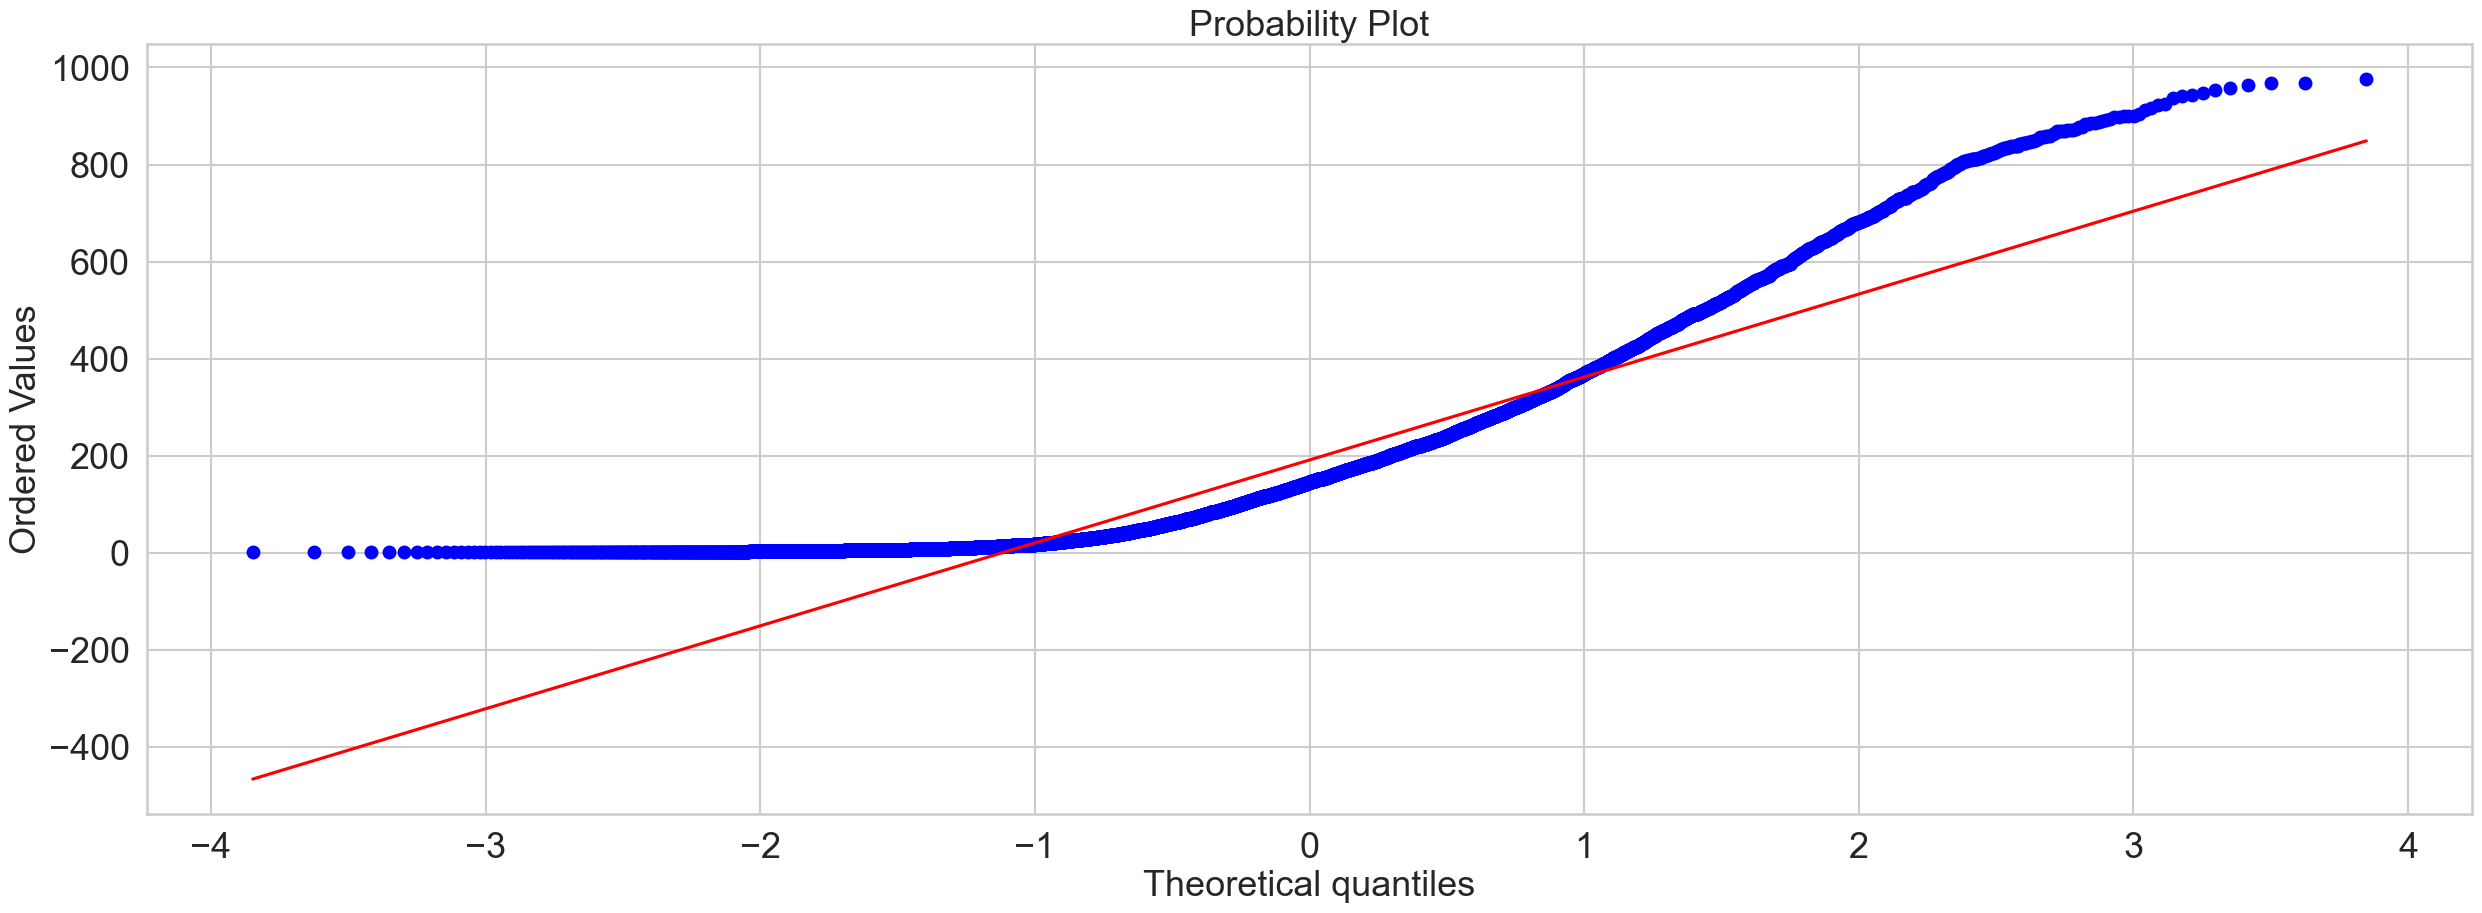

In [13]:
stats.probplot(y.total_count.tolist(), dist="norm", plot=plt)
plt.show()

### Encoding

In [10]:
#Looping through the list of categorical variables to transform and prepare a list of encoded attributes

cat_attr_list = ['season', 'is_holiday', 'weather_condition', 'is_workingday', 'hour', 'weekday', 'month', 'year']

encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc': return_obj[1],
                              'feature_df': return_obj[2],
                              'col_name': col}) 

In [12]:
#merging numeric and OHE categorical into one dataframe
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


In [14]:
train_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.64,0.65,0.1940,0,5,9,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.50,0.45,0.2239,13,2,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.86,0.47,0.5224,12,0,8,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.30,0.61,0.0000,2,3,2,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.54,0.19,0.4179,17,6,4,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Linear Regression 

### Training

In [15]:
#Creating instances
X = train_df_new
y = y.total_count.values.reshape(-1,1)

lin_reg = linear_model.LinearRegression()

In [16]:
#Using a cross validation to avoid overfitting

predicted = cross_val_predict(lin_reg, X, y, cv=10)

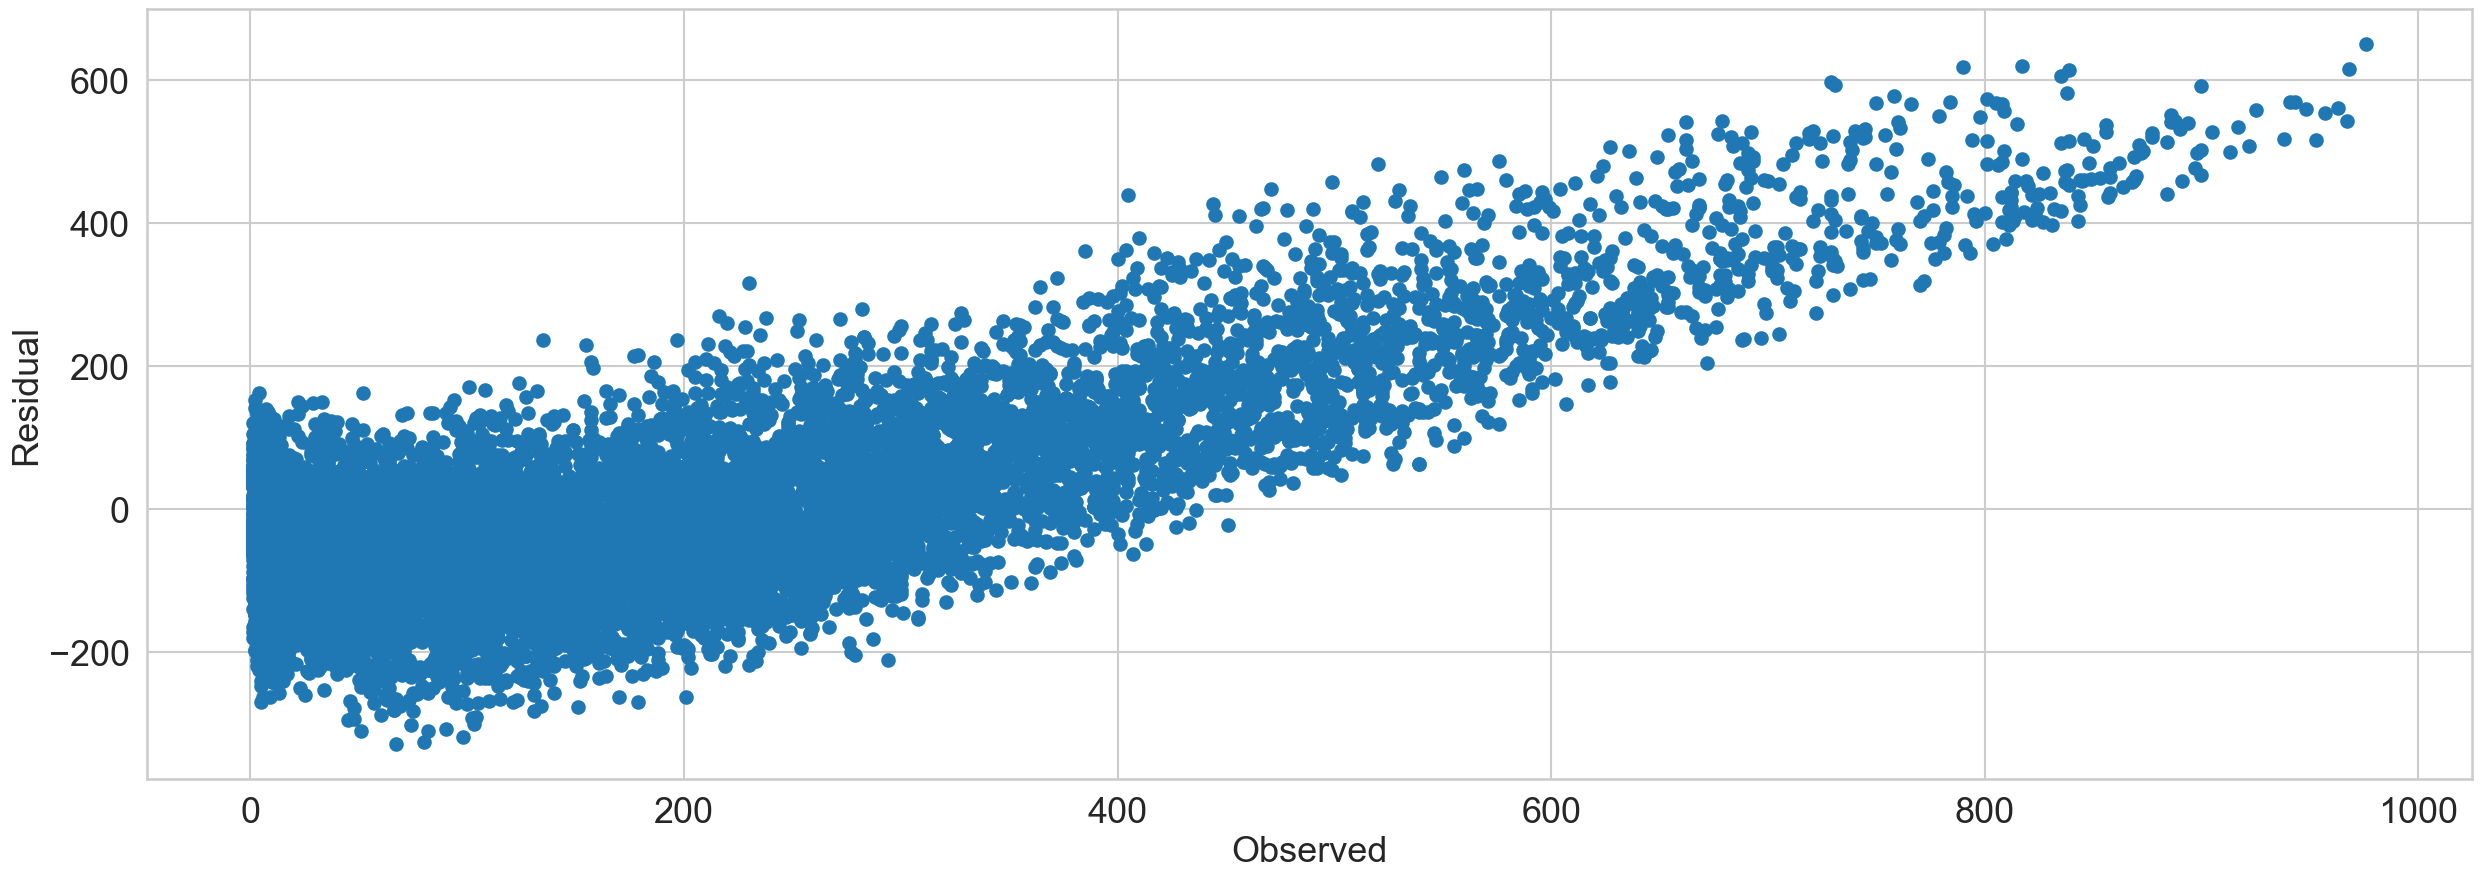

In [17]:
#Analyzing predictions
fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [18]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')

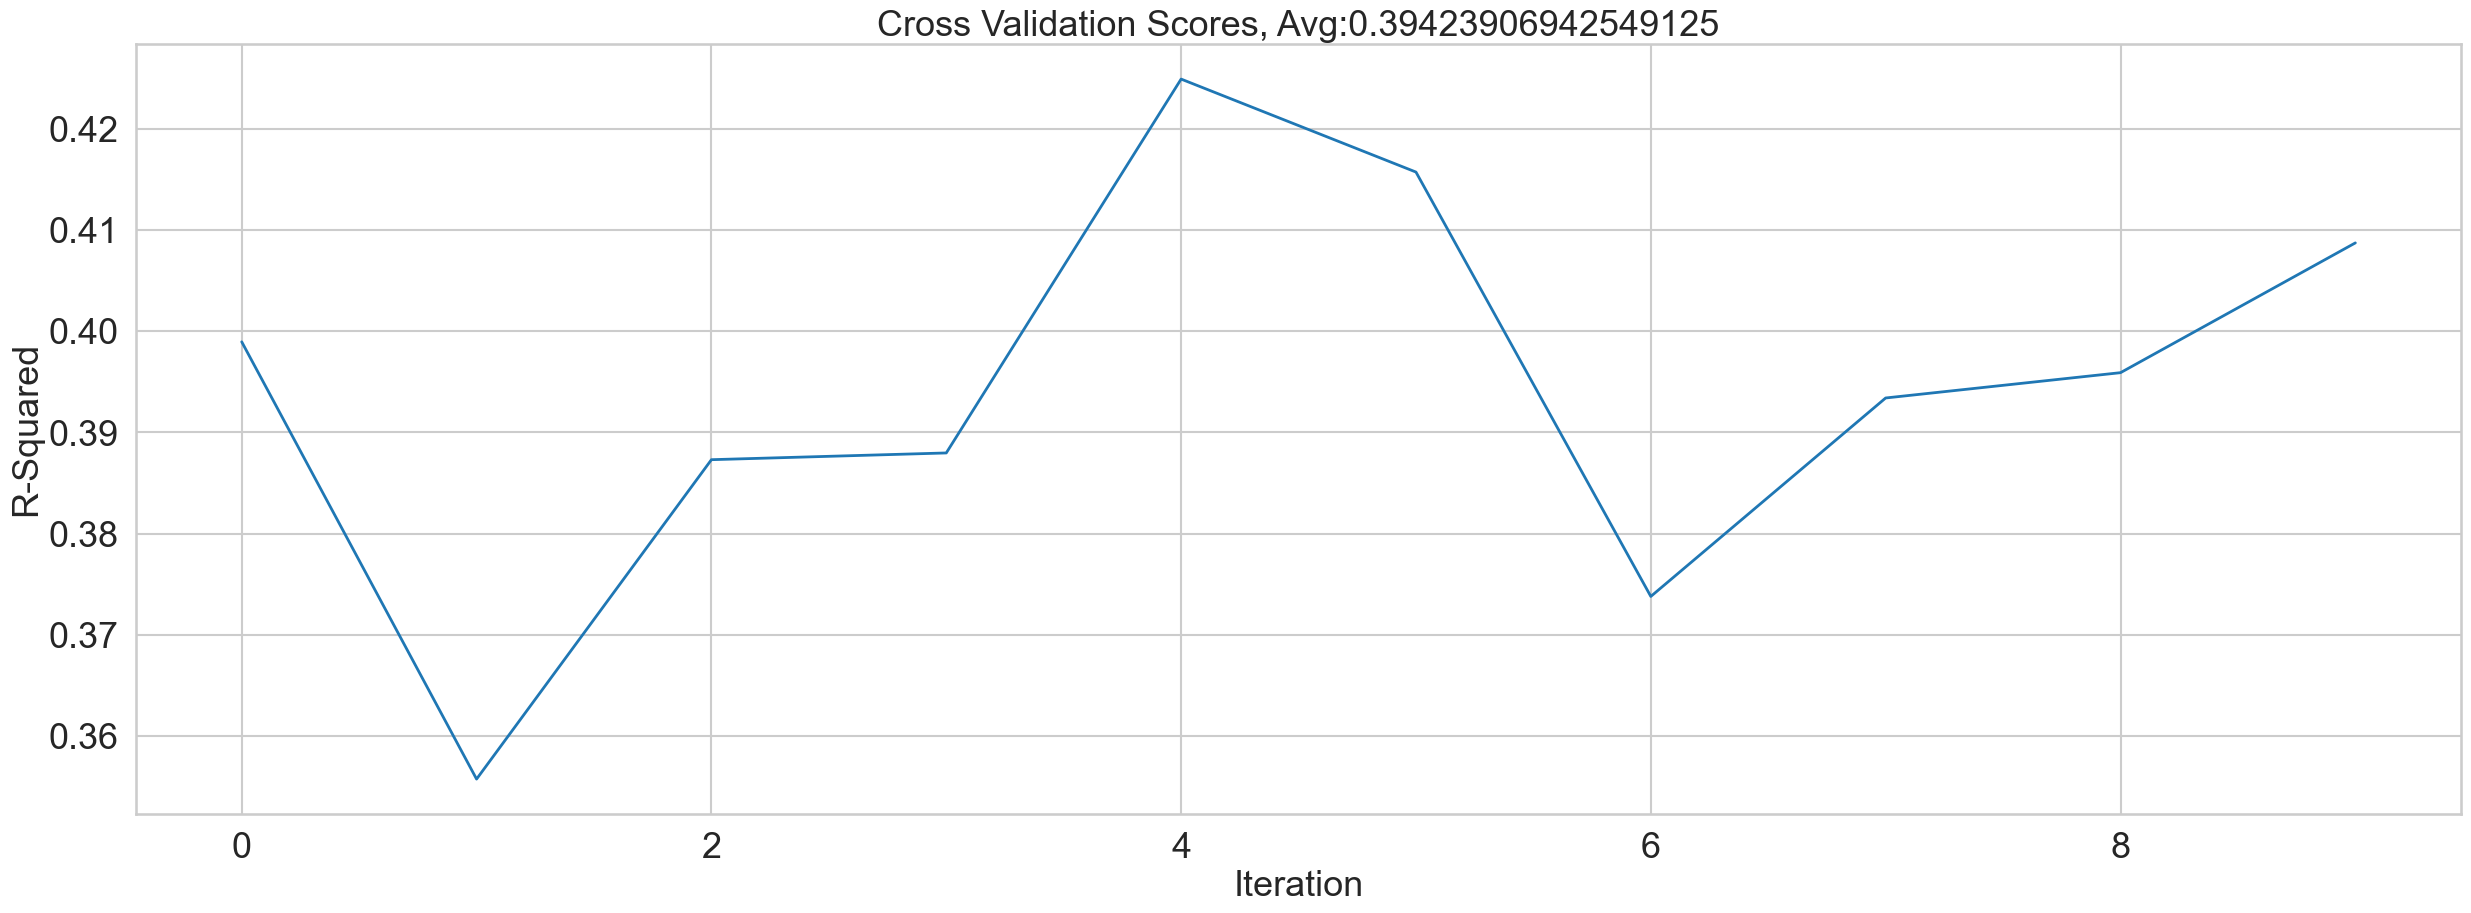

In [19]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [21]:
#Showing R-squared and MSE for every iteration
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[0.39894459 0.35575732 0.3873037  0.38796861 0.42489499 0.41571164
 0.37379762 0.39339864 0.39589746 0.40871611]
MSE::[-19612.38349313 -20800.77110185 -20256.54013607 -18545.99033804
 -18746.57816436 -21015.35560028 -21549.12876053 -21567.27946203
 -21044.42416385 -18899.05989574]


In [22]:
lin_reg.fit(X,y)


LinearRegression()

In [23]:
#Testing
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [24]:
test_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.80,0.27,0.1940,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.24,0.41,0.2239,20,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.32,0.66,0.2836,2,5,10,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.78,0.52,0.3582,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.26,0.56,0.3881,0,4,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [28]:
y_test.head()

,index,total_count
0,12830,425
1,8688,88
2,7091,4
3,12230,526
4,431,13


In [29]:
### Compare results / predictions
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

y_pred = lin_reg.predict(X_test)

residuals = y_test-y_pred

In [30]:
r2_score = lin_reg.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.4024409682673429
MSE: 19063.00


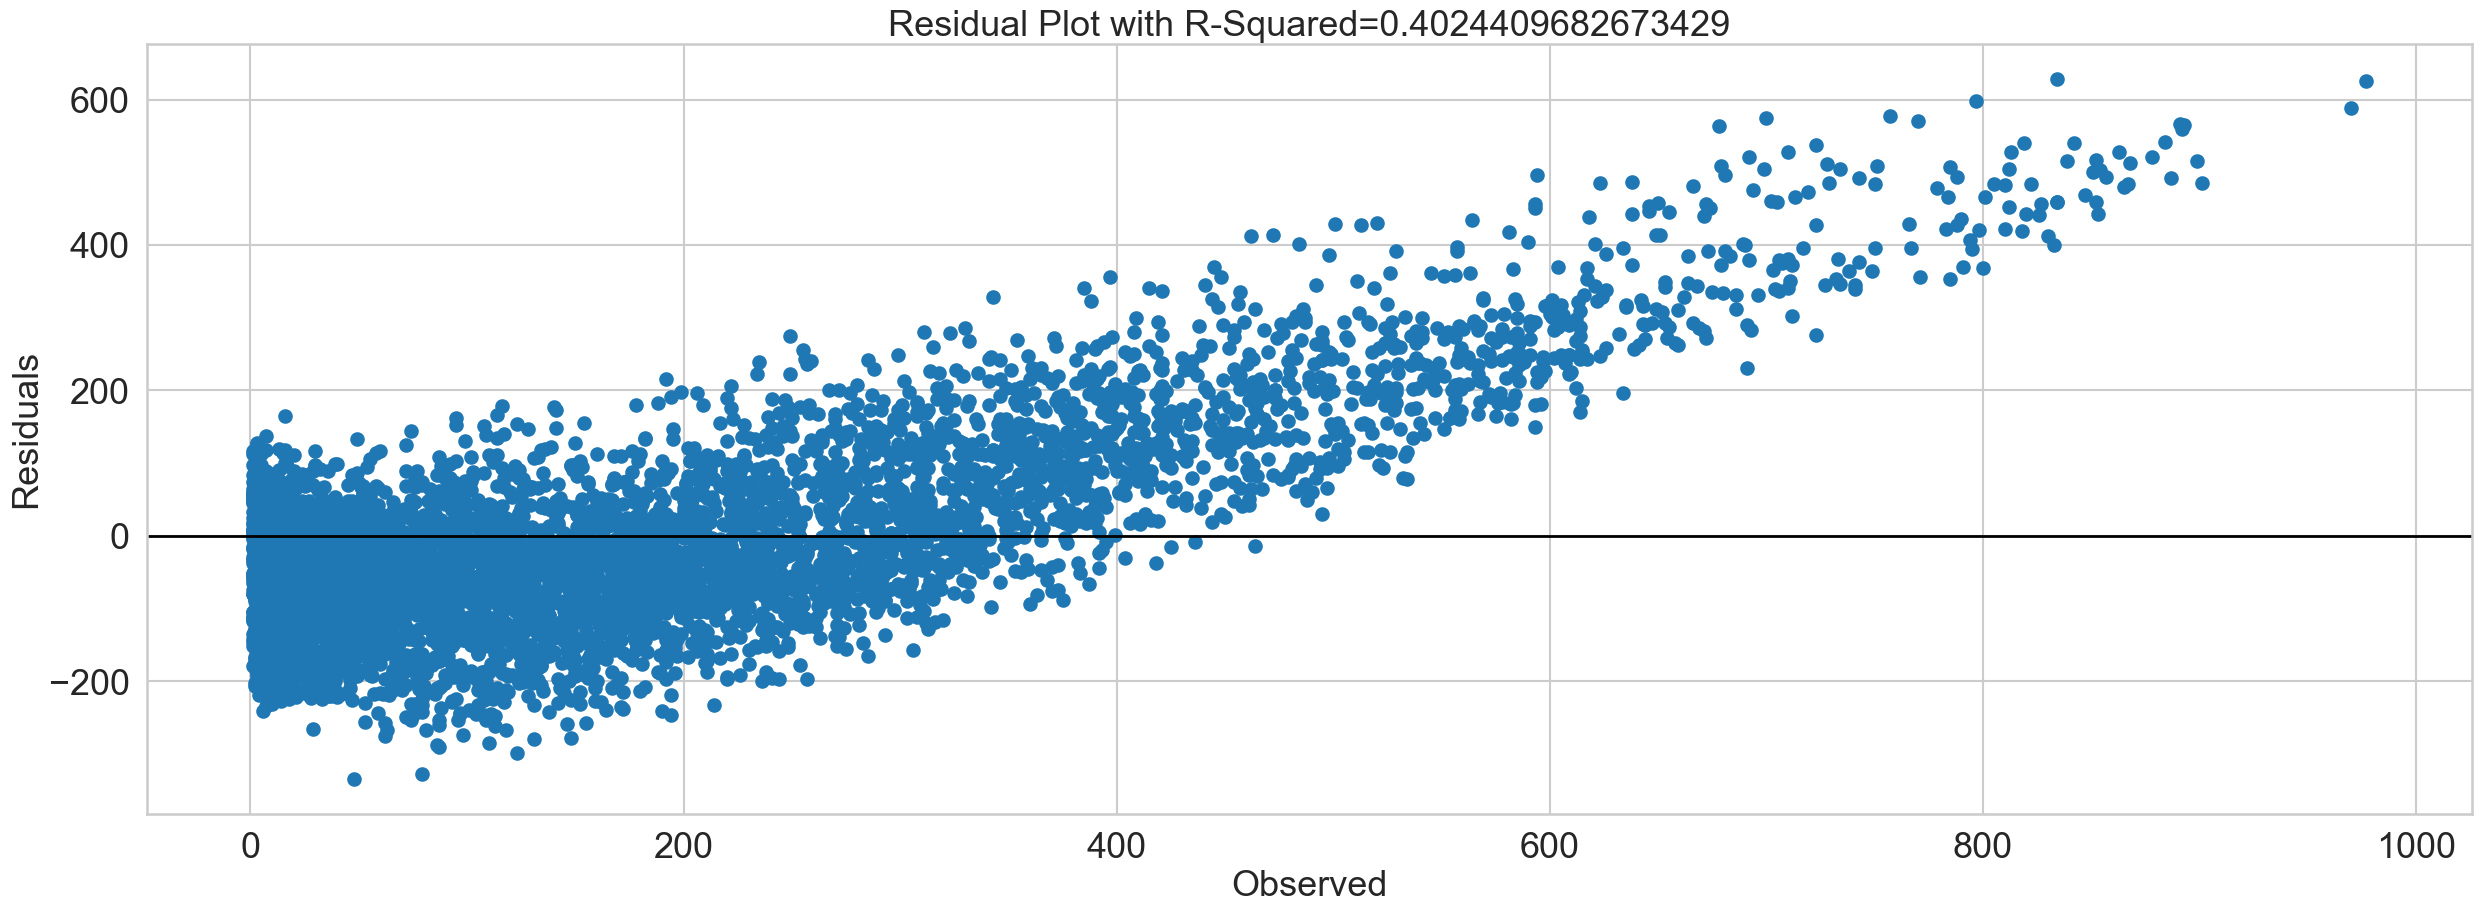

In [31]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(r2_score)))
plt.show()

Upon reviewing the results of linear regression applied to our dataset, it has been observed that the model fails to accurately capture the complexity of the relationships present in the data. This is reflected in a significant discrepancy between the model's predictions and the actual values observed in our dataset. Linear regression assumes a linear relationship between the independent variables and the dependent variable. However, in many cases, the underlying relationship between variables may be more complex and nonlinear. In our particular case, the nature of the data suggests the presence of nonlinear relationships that linear regression cannot effectively model. To address this limitation, it is essential to consider the use of models that can capture nonlinear relationships more accurately. This could involve implementing techniques such as polynomial regression, decision trees, or deep learning methods such as neural networks. By adopting a more flexible approach capable of modeling nonlinear relationships, we can significantly improve the predictive capability of our model and obtain more accurate and relevant results for our specific problem.